# Experiment 1. When synthetic dataset is a fair approximation of field data

This notebook accompanies [Alkhalifah, Wang and Ovcharenko, 2021](https://arxiv.org/abs/2109.05294). The [network](https://github.com/ovcharenkoo/mtl_low) learns mapping between high-frequency data (> 4 Hz) and low-frequency data (< 5 Hz). The training goes on synthetic while testing is on field data.

**Takeaway:** When synthetic data is build around field data no domain-adaptation might be needed to enable knowledge transfer from synthetic to field dataset in application to low-frequency  extrapolation.

In [1]:
# Most imports are in the shared_data_loading.ipynb
import os

# This is to prevent the error "this loop already running when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Constrain visibility of GPUs by selected one. This is to enable training of multiple networks each on its own device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# Where to save the trained model
root_pretrained = os.path.join('./pretrained_files/trained_nets/ex1_multi/')
root_out = os.path.join('./pretrained_files/trained_nets/ex1_multi/')

## Load data

1.8.1+cu102
3.8.3 (default, Oct 11 2020, 17:10:44) 
[GCC 7.5.0]
/home/ovcharoo/work/env_torch
{'high': {'flo': 4, 'btype': 'high', 'order': 8}, 'low': {'fhi': 5, 'btype': 'low', 'order': 8}, 'ulow': {'fhi': 2.5, 'btype': 'low', 'order': 8}}


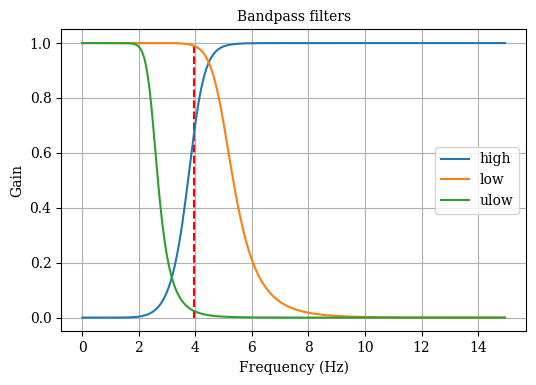

Load cubes from ./pretrained_files/data/syn_1024_el/...
(2765, 324, 376) (2765, 324, 376) (2765, 324, 376) (2765, 324, 376)
(154, 324, 376) (154, 324, 376) (154, 324, 376) (154, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
Processed data loaders: 2765 154
Load ./pretrained_files/data/noise_donors/cube_dst_te_h.npy
(80, 324, 376)
(80, 324, 446)
8


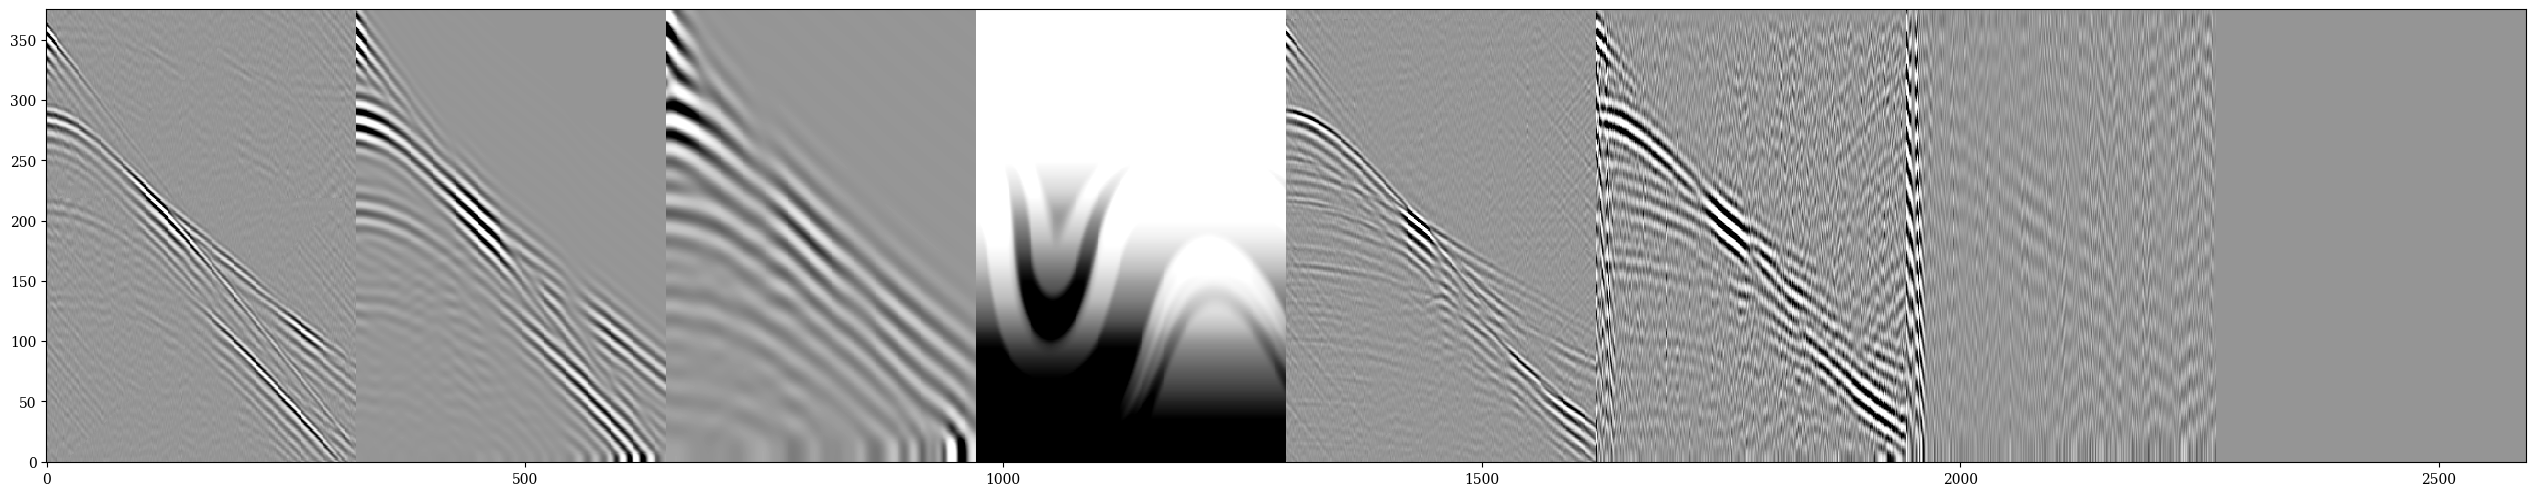

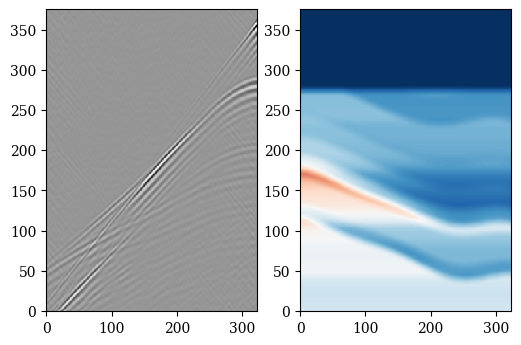

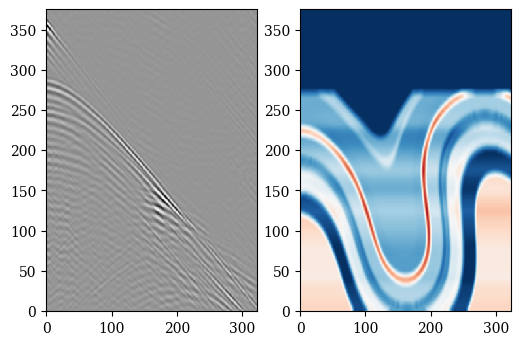

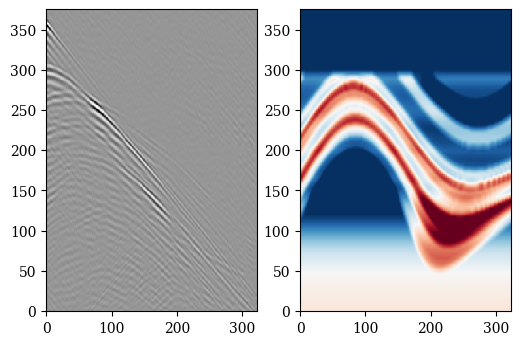

In [4]:
%run shared_data_loading.ipynb

# Multi-head architecture
Based on https://github.com/shepnerd/inpainting_gmcnn

In [5]:
# Import architectures
from utils.archs import HeadData, Encoder

## Head data
Takes the encoder bottleneck and upscales it to the dimensions of the input data.

In [6]:
summary(HeadData(layers=[(96, 32), (32, 16)],
             layers_out=(16, 1),
             kernel_sizes=[4, 4], 
             strides=[2, 2], 
             pads=[1, 1]).to(0), (96, 81, 94))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1         [-1, 32, 162, 188]          49,184
         LeakyReLU-2         [-1, 32, 162, 188]               0
   ConvTranspose2d-3         [-1, 16, 324, 376]           8,208
         LeakyReLU-4         [-1, 16, 324, 376]               0
            Conv2d-5         [-1, 16, 324, 376]           2,320
            Conv2d-6          [-1, 1, 324, 376]              17
          HeadData-7          [-1, 1, 324, 376]               0
Total params: 59,729
Trainable params: 59,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.79
Forward/backward pass size (MB): 61.34
Params size (MB): 0.23
Estimated Total Size (MB): 64.36
----------------------------------------------------------------



(tensor(59729), tensor(59729))

## Multi-column encoder
See _Image Inpainting via Generative Multi-column Convolutional Neural Networks_ by Yi Wang, Xin Tao, Xiaojuan Qi, Xiaoyong Shen, Jiaya Jia for details.

In [7]:
summary(Encoder(1).to(0), (1, 324, 376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 1, 330, 382]               0
            Conv2d-2          [-1, 8, 324, 376]             400
   ReflectionPad2d-3          [-1, 8, 330, 382]               0
            Conv2d-4         [-1, 16, 162, 188]           6,288
   ReflectionPad2d-5         [-1, 16, 168, 194]               0
            Conv2d-6         [-1, 16, 162, 188]          12,560
   ReflectionPad2d-7         [-1, 16, 168, 194]               0
            Conv2d-8           [-1, 32, 81, 94]          25,120
   ReflectionPad2d-9          [-1, 32, 87, 100]               0
           Conv2d-10           [-1, 32, 81, 94]          50,208
  ReflectionPad2d-11          [-1, 32, 87, 100]               0
           Conv2d-12           [-1, 32, 81, 94]          50,208
  ReflectionPad2d-13          [-1, 32, 93, 106]               0
           Conv2d-14           [-1, 32,

(tensor(838992), tensor(838992))

# Define training

https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example-pytorch.ipynb

https://pytorch.org/docs/stable/notes/amp_examples.html

https://paperswithcode.com/paper/multi-task-learning-using-uncertainty-to#code

https://towardsdatascience.com/self-paced-multitask-learning-76c26e9532d0

In [8]:
def plot_metrics(m, title=''):
    fig, ax = plt.subplots(1, 1)
    axis = [ax, ax.twinx()]
    colors = ['r', 'b', 'm', 'c', 'g', 'navy']
    for phase, loss_dict in m.items():
        color_phase = '--' if phase == 'val' else ''
        for i, (ln, val) in enumerate(loss_dict.items()):
            if 'w' in ln and phase == 'train':
                this_ax = axis[1]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            elif not 'w' in ln:
                this_ax = axis[0]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            
    axis[0].legend(loc='upper right')
    axis[1].legend(loc='lower right')
    plt.title(title)
    plt.show()

    
class LFNet(backbone.BaseModel):
    def __init__(self, opt, device, imodel=None):
        super().__init__()
        
        # Init model with fixed random seed
        this_seed = 1 + imodel * 100
        torch.manual_seed(this_seed)
        np.random.seed(this_seed)
        
        # Check gpu availability
        self.gpu_ids = [i for i in range(torch.cuda.device_count())]
        self.device = opt['device'] if opt['device'] else min(self.gpu_ids)
        self.imodel = imodel
        
        # Init architectures
        self.net_encoder = Encoder(1)          
        self.net_data = HeadData(layers=[(96, 32), (32, 16)],
             layers_out=(16, 1),
             kernel_sizes=[4, 4], 
             strides=[2, 2], 
             pads=[1, 1])
      
        # Init weights
        backbone.init_weights(self.net_encoder, 'kaiming')
        backbone.init_weights(self.net_data, 'kaiming')
            
        self.opt = opt
        self.load_dir = opt['load_pretrained']
        self.save_dir = opt['save_dir']
        self.epochs = opt['epochs']
        self.enable_scheduler = opt['scheduler']

        self.model_names = ['_encoder', '_data']
        self.phases = ['train', 'val']
        self.running_metrics_encoder = {}
        self.running_metrics_lr = {'train': {'lr_data': []}}
        for p in self.phases:
            self.running_metrics_encoder[p] = {'data': []}
        
        # Load if previous specified
        if self.load_dir:
            self.load_networks(self.load_dir, 0)
            self.load_history(self.load_dir)
            self.load_lr_history(self.load_dir)

        # MAE loss used for data and model fit
        self.loss_pix = nn.L1Loss()
        
        # Send to device
        self.net_encoder = self.net_encoder.to(self.device)
        self.net_data = self.net_data.to(self.device)

        # Cast to multiple GPUs
        if len(self.gpu_ids) > 1:
            print(f'DataParallel on {self.gpu_ids}')
            self.net_encoder = torch.nn.DataParallel(self.net_encoder, device_ids=self.gpu_ids)
            self.net_data = torch.nn.DataParallel(self.net_data, device_ids=self.gpu_ids)
            params_data = list(self.net_encoder.module.parameters()) + list(self.net_data.module.parameters())
        else:
            params_data = list(self.net_encoder.parameters()) + list(self.net_data.parameters())

        # Init separate optimizers for data and model heads
        self.optimizer_data = torch.optim.Adam(params_data, 
                                            lr=opt['lr_min'], betas=(0.5, 0.9), weight_decay=1e-5)
        
        # Init schedulers
        # https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
        self.scheduler_data = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_data, 
                                                        max_lr=opt['lr_max'],
                                                        cycle_momentum=False,
                                                        epochs=self.epochs,
                                                        steps_per_epoch=opt['len_loader'])

    def train_batch(self, data, phase, scaler):
        hs = data[0].to(self.device) # syn high-freq input data, > 4 Hz
        ls = data[1].to(self.device) # syn low-freq target data, < 5 Hz

        with torch.set_grad_enabled(phase != 'val'):
            # Enable automatic mixed precision training
            with autocast():
                # Predict
                hs_encoded = self.net_encoder(hs)
                lsp = self.net_data(hs_encoded) # low and ulow data

                # Data fit
                loss_data = self.loss_pix(lsp, ls.detach())
                loss_g = loss_data.sum()

            if phase == "train":
                self.optimizer_data.zero_grad()
                scaler.scale(loss_g).backward()
                scaler.step(self.optimizer_data)
                if self.enable_scheduler:
                    self.scheduler_data.step()
                scaler.update()
        return loss_data
    
    def train(self, dtrain, dval):
        os.makedirs(self.save_dir, exist_ok=True)
        t1 = time.time()
        for iepoch in range(self.epochs):
            clear_output()
            # Print outs
            if iepoch > 0:
                print(f'Model {self.imodel}. Stats for last epoch {iepoch}.')
                print('loss_data = {:.2f}'.format(loss_data.sum().item()))

            # Plot curves from previous epoch
            plot_metrics(self.running_metrics_encoder, title=f'Generator. Epoch {iepoch} / {self.epochs}')
            plot_metrics(self.running_metrics_lr, title=f'Learning Rate. Epoch {iepoch} / {self.epochs}')  
            print(f'{iepoch+1}/{self.epochs} ...')
                                                                
            for phase in self.phases:
                print(phase)
                if phase=='train':
                    data_loader = dtrain
                else:
                    data_loader = dval
                
                # FP16 converter for automatic-mixed-precision training
                scaler = torch.cuda.amp.GradScaler()
                prog_bar = tqdm.auto.tqdm(data_loader)
                for i, data in enumerate(prog_bar):
                    loss_data = self.train_batch(data, phase, scaler)
                self.running_metrics_encoder[phase]['data'].append(loss_data.sum().item())
            
            # Remember learning rates and sigmas per epoch
            self.running_metrics_lr['train']['lr_data'].append(self.optimizer_data.param_groups[0]["lr"]) 
            
            # Save networks every 5th epoch
            if iepoch == 0 or (iepoch + 1) % 5 == 0:
                print(f'Save state at epoch {iepoch}')
                self.save_networks(0)
                self.save_history(self.save_dir)
                self.save_lr_history(self.save_dir)

    def from_numpy(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, 0)
        return torch.from_numpy(x).type(torch.FloatTensor).to(self.device)

    def predict(self, h):
        if isinstance(h, np.ndarray):
            h = self.from_numpy(h)
        x = self.net_encoder(h)
        lp = self.net_data(x)

        # Predict ultra-low, low frequencies, subsurface model
        return sd.dcn(lp), sd.dcn(lp), sd.dcn(lp)

## Train an ensemble of networks

In [9]:
opt= {'batch_size': 4,
       'epochs': 81,
        'lr_min': 1e-5,
        'lr_max': 1e-3,
        'load_pretrained': '',
        'save_dir': root_out,
      'device': 0,
      'data_idx': 1,
      'w_tv': 1e-3,
      'scheduler': True}

dataset_train = torch.utils.data.DataLoader(jjloader_tr, 
                                            batch_size=opt['batch_size'], 
                                            shuffle=True, 
                                            num_workers=4, 
                                            drop_last=True, 
                                            pin_memory=True)
dataset_val = torch.utils.data.DataLoader(jjloader_te, 
                                          batch_size=opt['batch_size'], 
                                          shuffle=False, 
                                          num_workers=4, 
                                          drop_last=False, 
                                          pin_memory=True)
# Need the line below for OneCycle scheduler
opt['len_loader'] = len(dataset_train)

In [10]:
# # Uncomment below to train from scratch
# for i in range(0, 2):
#     opt['save_dir'] = root_out[:-1] + f'_{i}'
# #     opt['load_pretrained'] = root_pretrained[:-1] + f'_{i}'
#     opt['load_pretrained'] = ''
#     net = LFNet(opt, 0, i)
#     net.train(dataset_train, dataset_val)

## Load one pre-trained model

In [11]:
opt['load_pretrained'] = root_out[:-1] + f'_{0}'
net = LFNet(opt, opt, i)

initialize network with kaiming
initialize network with kaiming
Load weights for _encoder
Loading model from ./pretrained_files/trained_nets/ex1_multi_0/0_net_encoder.pth
Load weights for _data
Loading model from ./pretrained_files/trained_nets/ex1_multi_0/0_net_data.pth
Loading history from ./pretrained_files/trained_nets/ex1_multi_0/history_encoder.pkl...
Loading history from ./pretrained_files/trained_nets/ex1_multi_0/history_data.pkl...
Failed to load history form ./pretrained_files/trained_nets/ex1_multi_0/history_data.pkl, [Errno 2] No such file or directory: './pretrained_files/trained_nets/ex1_multi_0/history_data.pkl'
Loading history from ./pretrained_files/trained_nets/ex1_multi_0/history_lr.pkl...


No handles with labels found to put in legend.


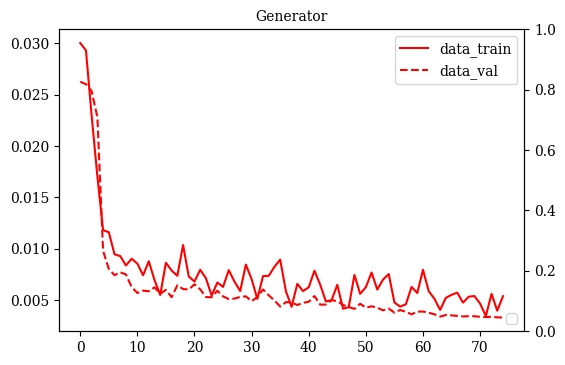

In [12]:
plot_metrics(net.running_metrics_encoder, title='Generator')

Structure of data, d:
```0 - syn input
1 - syn low
2 - syn ulow
3 - velocity model
4 - field input
5 - field low
6 - filed ulow
7 - velocity model (zeros)```

## Synthetic data

In [13]:
hs_true = d[0].copy()
print(hs_true.shape)
us_pred, ls_pred, ms_pred = net.predict(hs_true)
print(ls_pred.shape)

(1, 324, 376)
(1, 1, 324, 376)


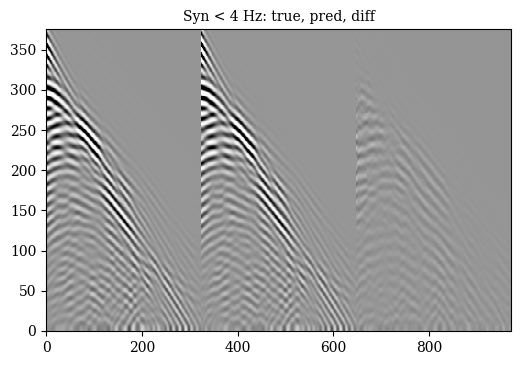

In [14]:
nt_clip=None
vlim_f = {'vmin': -0.25, 'vmax': 0.25}
vlim_2f = {'vmin': -0.125, 'vmax': 0.125}
fhp = 0.5
fedge = par['fedge']
dt_net = dt

ls_true = d[1].copy(); lst = ls_true[0,...]; ls = ls_pred[0,0,...]
# lst = ld.bandpass(lst, fs=1/dt_net, flo=fhp, btype='high')
# ls = ld.bandpass(ls, fs=1/dt_net, flo=fhp, btype='high')
vis.plot_shot(np.concatenate([lst, ls, lst - ls]), colorbar=False, **vlim_f,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')
# vis.plot_wiggles([lst[:, :nt_clip], ls[:, :nt_clip]], n=5)

## Field data

In [17]:
# Inference loader (field data normalized)
df = jloader_te.__getitem__(idx)

In [21]:
hf_true = df[4].copy()
lf_true = df[5].copy()
print(hf_true.shape, hf_true.max())
_, lf_pred, uf_pred = net.predict(hf_true)

(1, 324, 376) 0.7679477


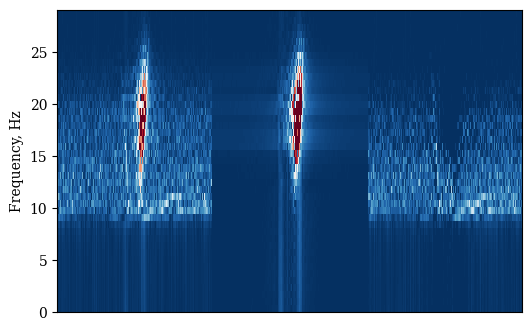

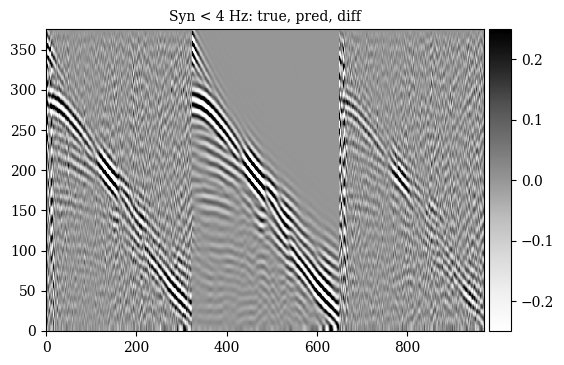

In [22]:
par_shot_auto = {'vmax': 0.25, 'vmin': -0.25}

lf = lf_pred.copy()[0, 0,...].astype(np.float32)
lft = lf_true.copy()[0,...]
# lft, lf = [ld.bandpass(v, fhi=2.5, dt=dt_net, btype='low') for v in [lft, lf]]
lft_fk, lf_fk = [vis.get_spectrum2(v, dt=dt_net, fmax=7)[0] for v in [lft, lf]]
vis.plot_spectrum2([lft_fk, lf_fk, lft_fk-lf_fk], plot_only=True, pclip=0.25, dt=dt_net)
vis.plot_shot(np.concatenate([lft, lf, lft - lf]), **par_shot_auto,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')
# vis.plot_spectra_dict({'known': lft, 'pred': lf}, dt_net, fmax=fedge)

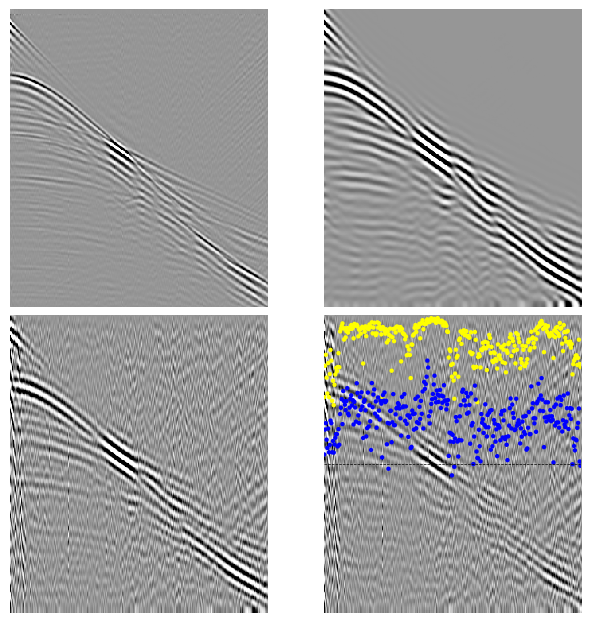

In [23]:
vis.imgrid(hf_true[0,...], lft, [lf], diff_of_diff=False, figsize=(8,8), **par_shot_auto, scatter_size=10)